In [1]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
from pathlib import Path


In [2]:
def extract_participant_data(df, study_id):
    """
    Extract all data for a specific participant from the REDCap dataset based on study_id.

    Parameters:
        df (pd.DataFrame): The DataFrame containing REDCap data.
        study_id (int): The study ID of the participant.

    Returns:
        pd.DataFrame: A DataFrame filtered for the given participant.
    """
    # Filter the data based on the provided study_id
    participant_data = df[df['study_id'] == study_id]
    
    # If no data is found, provide a meaningful message
    if participant_data.empty:
        print(f"No data found for participant with study ID: {study_id}")
        return pd.DataFrame()  # Return an empty DataFrame
    
    # Print the shape of the filtered DataFrame
    print(f"Extracted data shape for study ID {study_id}: {participant_data.shape}")
    
    return participant_data

In [3]:
def print_basic_info_for_report(participant_data):
    """
    Print basic information of the participant in a nice format for report generation.

    Parameters:
        participant_data (pd.DataFrame): The DataFrame containing data for the participant.
    """
    if participant_data.empty:
        print("No data available to print for report.")
        return

    # Extract relevant basic information for the report
    study_id = participant_data['study_id'].iloc[0]
    first_name = participant_data['fname'].iloc[0]
    last_name = participant_data['lname'].iloc[0]
    dob = participant_data['dob'].iloc[0] if 'dob' in participant_data.columns else 'N/A'
    gender = participant_data['gender'].iloc[0] if 'gender' in participant_data.columns else 'N/A'
    enrolment_date = participant_data['icdate'].iloc[0] if 'icdate' in participant_data.columns else 'N/A'

    # Calculate age at report
    age = 'N/A'
    if dob != 'N/A':
        try:
            dob_date = datetime.strptime(dob, '%d/%m/%Y')
            today = datetime.today()
            age = today.year - dob_date.year - ((today.month, today.day) < (dob_date.month, dob_date.day))
            dob = dob_date.strftime('%d / %m / %Y')
        except ValueError:
            print(f"Date of Birth '{dob}' is not in the expected format and cannot be converted.")
    if enrolment_date != 'N/A':
        try:
            enrolment_date = datetime.strptime(enrolment_date, '%d/%m/%Y').strftime('%d / %m / %Y')
        except ValueError:
            print(f"Enrolment Date '{enrolment_date}' is not in the expected format and cannot be converted.")

    # Print the basic information in a formatted manner
    print(f"\nParticipant Report Summary:\n")
    print(f"Study ID: {study_id}")
    print(f"Name: {first_name} {last_name}")
    print(f"Date of Birth: {dob}")
    print(f"Age: {age}")
    print(f"Gender: {gender}")
    print(f"Enrolment Date: {enrolment_date}\n")


In [4]:
def extract_and_print_assessment_dates(participant_data):
    """
    Extract treadmill assessment dates and calculate time differences to provide a temporal overview of training.

    Parameters:
        participant_data (pd.DataFrame): The DataFrame containing data for the participant.

    Returns:
        list: A list of strings summarizing the treadmill assessment timeline.
    """
    if participant_data.empty:
        print("No data available to extract assessment dates.")
        return []

    # Extract treadmill assessment dates based on column named 'treadmill'
    treadmill_data = participant_data[['treadmill']].dropna()
    if treadmill_data.empty:
        print("No treadmill assessment data found.")
        return []

    # Extract and sort unique assessment dates
    try:
        print('here')
        treadmill_dates = treadmill_data['treadmill'].apply(lambda x: datetime.strptime(x.split()[0], '%d/%m/%Y'))
        treadmill_dates = treadmill_dates.sort_values()
    except ValueError as e:
        print(f"Error parsing dates: {e}")
        return []

    if treadmill_dates.empty:
        print("No valid treadmill assessment dates available.")
        return []

    # Calculate number of training sessions
    training_date_data = participant_data[participant_data['training_date'].notna()]
    number_of_trainings = training_date_data.shape[0]

    # Create summary for report
    timeline_summary = []
    previous_date = None
    for current_date in treadmill_dates:
        if previous_date:
            delta = current_date - previous_date
            timeline_summary.append(f"Assessment on {current_date.strftime('%d / %m / %Y')} (Days since last assessment: {delta.days})")
        else:
            timeline_summary.append(f"Assessment on {current_date.strftime('%d / %m / %Y')} (First assessment)")
        previous_date = current_date

    # Print timeline summary
    for entry in timeline_summary:
        print(entry)
 
    # Print number of training sessions
    print(f"Total number of training sessions completed: {number_of_trainings}")
    
    if timeline_summary:
        paragraph = (
            f"Figure 1| presents the timeline of the participant’s training periods and assessments. "
            f"The first assessment was conducted on {timeline_summary[0].split('on ')[1].split(' (')[0]}. "
        )
        for i in range(1, len(timeline_summary)):
            days_since = timeline_summary[i].split('Days since last assessment: ')[1].replace(')', '')
            paragraph += (
                f"The subsequent assessments were carried out on {timeline_summary[i].split('on ')[1].split(' (')[0]} "
                f"({days_since} days after the previous assessment), "
            )
        paragraph += (
            f"The participant completed {number_of_trainings} training sessions, demonstrating consistent engagement throughout the training period."
        )
        print("\n" + paragraph + "\n")

In [53]:
def plot_timeline(participant_data):
    """
    Plot a horizontal timeline of treadmill assessments for visualization.

    Parameters:
        participant_data (pd.DataFrame): The DataFrame containing data for the participant.
    """
    # Extract treadmill assessment dates
    treadmill_data = participant_data[['treadmill']].dropna()
    
    try:
        
        treadmill_dates = treadmill_data['treadmill'].apply(lambda x: datetime.strptime(x.split()[0], '%d/%m/%Y'))
        treadmill_dates = treadmill_dates.sort_values()
    except ValueError as e:
        print(f"Error parsing dates for plotting: {e}")
        return

    if treadmill_dates.empty:
        print("No valid treadmill assessment dates available for plotting.")
        return

    # Calculate the number of days since the first assessment for each date
    start_date = treadmill_dates.iloc[0]
    days_since_start = [(date - start_date).days for date in treadmill_dates]
    today = datetime.today()
    days_since_today = (today - start_date).days
    # Define colors for each assessment
    colors = plt.cm.tab10(np.linspace(0, 1, len(days_since_start)))

    # Plot a horizontal timeline
    fig, ax = plt.subplots(figsize=(10, 2))
    #ax.plot(days_since_start, [1] * len(days_since_start), linewidth=4, color='black')  # Black line
    # Draw the black line from Day 0 to today
    ax.plot([0, days_since_today], [1, 1], linewidth=4, color='black')

    # Annotate each assessment with different colors
    # Annotate each assessment with different colors, label placement
    for i, day in enumerate(days_since_start):
        ax.plot(day, 1, 'o', markersize=10, color=colors[i])
        label_y = 0.75 if i == 1 else 1.25
        ax.text(day, label_y, f"Day {day}\nAssessment {i+1}", fontsize=10, ha='center', color=colors[i])


    # Set limits and labels
    ax.set_ylim(0.5, 1.5)
    ax.set_yticks([])
    ax.set_xlabel('Days Since First Assessment')
    ax.set_title('Treadmill Assessment Timeline')
    ax.grid(axis='x', linestyle='--', alpha=0.7)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.set_xlim(0, 610)
    plt.rcParams.update({
        # Titles
        "axes.titlesize": 18,
        "axes.titleweight": "bold",

        # Axis labels
        "axes.labelsize": 18,
        "axes.labelweight": "bold",

        # Tick labels
        "xtick.labelsize": 14,
        "ytick.labelsize": 14,
        "font.weight": "bold",            # makes tick text bold
        "xtick.major.width": 1.2,         # thicker ticks-and-spines help readability
        "ytick.major.width": 1.2,
        "axes.linewidth": 1.2,

        # Legend
        "legend.fontsize": 14,
        "legend.title_fontsize": 15,
        "legend.facecolor": "white",
        "legend.edgecolor": "black",
        "legend.framealpha": 1.0,         # fully opaque legend box
    })
    plt.savefig(FIGURE_DIR / "treadmill_assessment_timeline.png", dpi=300, bbox_inches='tight')
    plt.show()
    print('Timeline saved as treadmill_assessment_timeline.png in the figures directory.')

In [54]:
def plot_training_summary(participant_data):
    """
    Plot separate summaries of training modes (high vs medium body weight support).

    Parameters:
        participant_data (pd.DataFrame): The DataFrame containing data for the participant.
    """
    if participant_data.empty:
        print("No data available for plotting training summary.")
        return

    # Extract relevant training data
    training_data = participant_data[['training_mode', 'training_bws', 'training_time']].dropna()

    if training_data.empty:
        print("No valid training data available.")
        return

    # Split data by training mode
    high_bws_data = training_data[training_data['training_mode'] == 1]
    medium_bws_data = training_data[training_data['training_mode'] == 2]

    # Calculate counts, average BWS, and total training time
    high_bws_count = high_bws_data.shape[0]
    medium_bws_count = medium_bws_data.shape[0]
    high_bws_avg = high_bws_data['training_bws'].mean() if high_bws_count > 0 else 0
    medium_bws_avg = medium_bws_data['training_bws'].mean() if medium_bws_count > 0 else 0
    high_bws_total_time = high_bws_data['training_time'].sum() / 60 if high_bws_count > 0 else 0  # Convert to hours
    medium_bws_total_time = medium_bws_data['training_time'].sum() / 60 if medium_bws_count > 0 else 0  # Convert to hours

    # Define colors for consistency across plots
    high_bws_color = 'deepskyblue'
    medium_bws_color = 'lightcoral'

    # Create a single figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Plot bar chart for number of sessions by training mode
    labels = ['High BWS', 'Medium BWS']
    counts = [high_bws_count, medium_bws_count]
    ax1.bar(labels, counts, color=[high_bws_color, medium_bws_color], alpha=0.7, edgecolor='black')
    ax1.set_ylabel('Number of Sessions', fontsize=16)
    ax1.set_title('Number of Sessions', fontsize=18)
    ax1.tick_params(axis='both', which='major', labelsize=14)
    ax1.spines['right'].set_visible(False)
    ax1.spines['top'].set_visible(False)
    # Plot box plot for BWS level by training mode
    bws_levels = [high_bws_data['training_bws'], medium_bws_data['training_bws']]
    ax2.boxplot(bws_levels, labels=['High BWS', 'Medium BWS'], patch_artist=True, showfliers=False,
                boxprops=dict(facecolor=high_bws_color, color='black'),
                medianprops=dict(color='red'), whiskerprops=dict(color='black'), capprops=dict(color='black'))
    ax2.boxplot([medium_bws_data['training_bws']], positions=[2], patch_artist=True, showfliers=False,
                boxprops=dict(facecolor=medium_bws_color, color='black'),
                medianprops=dict(color='red'), whiskerprops=dict(color='black'), capprops=dict(color='black'))
    ax2.set_ylabel('Body Weight Support (%)', fontsize=16)
    ax2.set_title('BWS Level by Training Mode', fontsize=18)
    ax2.tick_params(axis='both', which='major', labelsize=14)
    ax2.set_xticks([1, 2])
    ax2.set_xticklabels(['High BWS', 'Medium BWS'], fontsize=14, rotation=0)
    ax2.tick_params(axis='x', pad=10)  # Add extra padding for better spacing
    ax2.spines['right'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    plt.rcParams.update({
        # Titles
        "axes.titlesize": 18,
        "axes.titleweight": "bold",

        # Axis labels
        "axes.labelsize": 18,
        "axes.labelweight": "bold",

        # Tick labels
        "xtick.labelsize": 14,
        "ytick.labelsize": 14,
        "font.weight": "bold",            # makes tick text bold
        "xtick.major.width": 1.2,         # thicker ticks-and-spines help readability
        "ytick.major.width": 1.2,
        "axes.linewidth": 1.2,

        # Legend
        "legend.fontsize": 14,
        "legend.title_fontsize": 15,
        "legend.facecolor": "white",
        "legend.edgecolor": "black",
        "legend.framealpha": 1.0,         # fully opaque legend box
    })

    # Adjust layout to remove extra whitespace
    plt.tight_layout()
    plt.savefig(FIGURE_DIR / 'combined_training_summary.png', bbox_inches='tight')
    plt.show()

    # Print descriptive paragraph for the report
    paragraph = (
        f"The training summary graph provides an overview of the participant's training sessions with different levels of body weight support (BWS). "
        "The level of BWS shown is the percentage of body weight support provided by the machine, meaning the participant is supporting the remainder to reach 100%. "
        f"The participant completed {high_bws_count} high BWS sessions with an average support level of {high_bws_avg:.2f}% and spent a total of {high_bws_total_time:.2f} hours in these sessions. "
        f"Additionally, {medium_bws_count} medium BWS sessions were completed with an average support level of {medium_bws_avg:.2f}% and a total of {medium_bws_total_time:.2f} hours spent. "
        "The first subplot illustrates the total number of sessions completed with high and medium BWS. "
        "The second subplot presents a box plot showing the distribution of BWS levels for each training mode. "
        "The high BWS sessions are designed to provide more assistance, which helps participants maintain a steady gait while reducing joint stress. "
        "In contrast, the medium BWS sessions offer moderate support, encouraging participants to bear more of their own body weight, thereby enhancing muscle engagement. "
        "This visualization helps in understanding the intensity and progression of the participant's rehabilitation program."
    )
    print("\n" + paragraph + "\n")


In [55]:
def training_performance(participant_data):
    """
    Visualize the treadmill speed and distance covered per session.

    Parameters:
        participant_data (pd.DataFrame): The DataFrame containing data for the participant.
    """
    if 'trd_speed' not in participant_data.columns or 'training_time' not in participant_data.columns:
        print("Treadmill speed or training time data is not available for plotting.")
        return

    # Extract treadmill speed and training time data
    treadmill_speed = participant_data['trd_speed'].dropna()
    training_time = participant_data['training_time'].dropna()

    if treadmill_speed.empty or training_time.empty:
        print("No valid treadmill speed or training time data available.")
        return

    # Ensure speed and time data are aligned by index
    valid_index = treadmill_speed.index.intersection(training_time.index)
    treadmill_speed = treadmill_speed.loc[valid_index]
    training_time = training_time.loc[valid_index]

    # Calculate distance covered per session (km/h * hours)
    distance_covered = ((treadmill_speed * (training_time / 60)) - 0.5).dropna()  # Convert minutes to hours and subtract 0.5 km

    # Define figure and axes for subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

    # Plot 1: Line Plot with a Fitted Trendline for Treadmill Speed
    ax1.plot(treadmill_speed.index, treadmill_speed, color='blue', linewidth=2, alpha=0.3)
    z_speed = np.polyfit(treadmill_speed.index, treadmill_speed, 3)
    p_speed = np.poly1d(z_speed)
    ax1.plot(treadmill_speed.index, p_speed(treadmill_speed.index), color='red', linestyle='--', linewidth=3)
    ax1.set_title('Treadmill Speed', fontsize=16)
    ax1.set_xlabel('Session Number', fontsize=14)
    ax1.set_ylabel('Speed (km/h)', fontsize=14)
    ax1.tick_params(axis='both', which='major', labelsize=12)
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)

    # Plot 2: Bar Plot of Average Distance Covered per Session with Fitted Trendline
    ax2.bar(distance_covered.index, distance_covered, color='skyblue', alpha=0.3, edgecolor='black')
    z_distance = np.polyfit(distance_covered.index, distance_covered, 3)
    p_distance = np.poly1d(z_distance)
    ax2.plot(distance_covered.index, p_distance(distance_covered.index), color='red', linestyle='--', linewidth=3)
    ax2.set_title('Distance Covered per Training', fontsize=16)
    ax2.set_xlabel('Session Number', fontsize=14)
    ax2.set_ylabel('Distance Covered (km)', fontsize=14)
    ax2.tick_params(axis='both', which='major', labelsize=12)
    ax2.spines['top'].set_visible(False)
    ax2.spines['left'].set_visible(False)
    plt.rcParams.update({
        # Titles
        "axes.titlesize": 18,
        "axes.titleweight": "bold",

        # Axis labels
        "axes.labelsize": 18,
        "axes.labelweight": "bold",

        # Tick labels
        "xtick.labelsize": 14,
        "ytick.labelsize": 14,
        "font.weight": "bold",            # makes tick text bold
        "xtick.major.width": 1.2,         # thicker ticks-and-spines help readability
        "ytick.major.width": 1.2,
        "axes.linewidth": 1.2,

        # Legend
        "legend.fontsize": 14,
        "legend.title_fontsize": 15,
        "legend.facecolor": "white",
        "legend.edgecolor": "black",
        "legend.framealpha": 1.0,         # fully opaque legend box
    })

    # Adjust layout to make space for both plots
    plt.tight_layout()
    plt.savefig(FIGURE_DIR / 'training_performance_with_distance_fit.png', bbox_inches='tight')
    plt.show()

    # Print descriptive paragraph for the report
    speed_start = treadmill_speed.iloc[0]
    speed_max = treadmill_speed.max()
    distance_start = distance_covered.iloc[0]
    distance_max = distance_covered.max()
    speed_increase = speed_max - speed_start
    distance_increase = distance_max - distance_start

    print("\nThe plot on the left provides an overview of the participant's treadmill speed progression during each session.")
    print(f"The participant started training at a speed of {speed_start:.1f} km/h and reached a maximum of {speed_max:.1f} km/h, signifying an increase of {speed_increase:.1f} km/h.")
    print("The plot on the right presents the distance covered during each session, along with a fitted trendline to show the overall trend in distance.")
    print(f"The participant started by covering a distance of {distance_start:.1f} km and reached a maximum of {distance_max:.1f} km per session, signifying an increase of {distance_increase:.1f} km.")
    print("This visualization provides insight into the participant's performance and improvements in terms of speed and distance covered over time.")


In [56]:
from matplotlib.ticker import AutoMinorLocator
import os
print(os.getcwd())

def plot_training_density_vs_max_speed(training_rows):
    """
    Plot the number of sessions per week vs maximum treadmill speed per week.
    Accepts pre-filtered training session rows.
    """
    import matplotlib.pyplot as plt
    import matplotlib.dates as mdates
    from matplotlib.ticker import MaxNLocator
    
    
    plt.rcParams.update({
        "axes.titlesize": 22,      # ↑ from 18→22
        "axes.titleweight": "bold",
        "axes.labelsize": 20,      # ↑ from 16→20
        "axes.labelweight": "bold",
        "xtick.labelsize": 16,     # ↑ from 14→16
        "ytick.labelsize": 16,
        "font.weight": "bold",
        "axes.linewidth": 1.5,
    })
    # Parse training_date if not already datetime
    if training_rows['training_date'].dtype == object:
        training_rows['training_date'] = pd.to_datetime(training_rows['training_date'], format='%d/%m/%Y %H:%M', errors='coerce')

    training_rows = training_rows.dropna(subset=['training_date', 'trd_speed'])
    if training_rows.empty:
        print("No valid training sessions with both date and speed.")
        return

    # Resample by week: count sessions, max speed
    training_rows['week'] = training_rows['training_date'].dt.to_period('W').apply(lambda r: r.start_time)
    weekly_density = training_rows.groupby('week').size()
    weekly_max_speed = training_rows.groupby('week')['trd_speed'].max()

    df = pd.DataFrame({'session_count': weekly_density, 'max_speed': weekly_max_speed}).fillna(0)

    fig, ax1 = plt.subplots(figsize=(12, 6))

    # Max speed line (left axis)
    ax1.plot(df.index, df['max_speed'], color='tab:blue', marker='o', linewidth=2, label='Max Speed (km/h)')
    ax1.set_ylabel('Speed (km/h)', color='tab:blue')
    ax1.tick_params(axis='y', labelcolor='tab:blue')
    ax1.set_xlabel('Date')
    ax1.set_title('Weekly Training Sessions vs Speed')

    # Set axes (spines) to black
    for spine in ax1.spines.values():
        spine.set_visible(True)
        spine.set_color('black')
        spine.set_linewidth(1.5)
    ax1.spines['top'].set_visible(False)
    #ax1.yaxis.set_minor_locator(AutoMinorLocator())
    ax1.tick_params(axis='y', which='minor', length=4, width=1)
    # Same for secondary axis
    ax2 = ax1.twinx()
    for spine in ax2.spines.values():
        spine.set_visible(True)
        spine.set_color('black')
        spine.set_linewidth(1.5)
    ax2.spines['top'].set_visible(False)
    #ax2.yaxis.set_minor_locator(AutoMinorLocator())
    ax2.tick_params(axis='y', which='minor', length=4, width=1)
    # Session count bars (right axis)
    ax2.bar(df.index, df['session_count'], width=4, color='tab:orange', alpha=0.3, label='Session Count', zorder=1)
    ax2.set_ylabel('Session Count', color='tab:orange')
    ax2.tick_params(axis='y', labelcolor='tab:orange')
    ax2.yaxis.set_major_locator(MaxNLocator(integer=True))

    # Format x-axis ticks as MM-YY
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%m-%y'))
    ax1.tick_params(axis='x', rotation=0)

    # Remove grid
    ax1.grid(False)
    ax2.grid(False) 

    # ── Global font/line style tweaks ───────────────────────────────────────────────
    plt.rcParams.update({
        # Titles
        "axes.titlesize": 18,
        "axes.titleweight": "bold",

        # Axis labels
        "axes.labelsize": 20,
        "axes.labelweight": "bold",

        # Tick labels
        "xtick.labelsize": 14,
        "ytick.labelsize": 14,
        "font.weight": "bold",            # makes tick text bold
        "xtick.major.width": 1.2,         # thicker ticks-and-spines help readability
        "ytick.major.width": 1.2,
        "axes.linewidth": 1.2,

        # Legend
        "legend.fontsize": 14,
        "legend.title_fontsize": 15,
        "legend.facecolor": "white",
        "legend.edgecolor": "black",
        "legend.framealpha": 1.0,         # fully opaque legend box
    })



    fig.tight_layout()
    plt.savefig(FIGURE_DIR / 'training_density_vs_maxspeed.png', bbox_inches='tight', dpi=300)
    plt.show()
    print(FIGURE_DIR.resolve())
    print((FIGURE_DIR / 'training_density_vs_maxspeed.png').resolve())

    print(f"Plotted {len(df)} weeks. Speed and session count shown for each week.")


c:\git\alterg-pipeline\notebooks\training


In [57]:
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

# Set your figure directory here
FIGURE_DIR = Path("figures")
FIGURE_DIR.mkdir(exist_ok=True)

def training_performance_separate(participant_data):
    """
    Visualize the treadmill speed and distance covered per session as separate figures.

    Parameters:
        participant_data (pd.DataFrame): The DataFrame containing data for the participant.
    """
    # Set rcParams BEFORE plotting
    plt.rcParams.update({
        "axes.titlesize": 20,
        "axes.titleweight": "bold",
        "axes.labelsize": 16,
        "axes.labelweight": "bold",
        "xtick.labelsize": 14,
        "ytick.labelsize": 14,
        "font.family": "serif",
        "axes.linewidth": 1.3,
    })

    if 'trd_speed' not in participant_data.columns or 'training_time' not in participant_data.columns:
        print("Treadmill speed or training time data is not available for plotting.")
        return

    # Extract treadmill speed and training time data
    treadmill_speed = participant_data['trd_speed'].dropna()
    training_time = participant_data['training_time'].dropna()

    if treadmill_speed.empty or training_time.empty:
        print("No valid treadmill speed or training time data available.")
        return

    # Ensure speed and time data are aligned by index
    valid_index = treadmill_speed.index.intersection(training_time.index)
    treadmill_speed = treadmill_speed.loc[valid_index]
    training_time = training_time.loc[valid_index]

    # Calculate distance covered per session (km/h * hours)
    distance_covered = ((treadmill_speed * (training_time / 60)) - 0.5).dropna()

    # --------- Figure 1: Treadmill Speed ---------
    plt.figure(figsize=(9, 6))
    plt.plot(treadmill_speed.index, treadmill_speed, color='cornflowerblue', linewidth=2, alpha=0.4, label='Session Speed')
    # Polynomial fit
    z_speed = np.polyfit(treadmill_speed.index, treadmill_speed, 3)
    p_speed = np.poly1d(z_speed)
    plt.plot(treadmill_speed.index, p_speed(treadmill_speed.index), color='red', linestyle='--', linewidth=3, label='Trend')
    plt.title('Treadmill Speed')
    plt.xlabel('Session Number')
    plt.ylabel('Speed (km/h)')
    plt.grid(False)
    # Fix spines
    ax = plt.gca()
    for pos in ['left', 'bottom']:
        ax.spines[pos].set_visible(True)
    for pos in ['right', 'top']:
        ax.spines[pos].set_visible(False)
    plt.tight_layout()
    plt.savefig(FIGURE_DIR / 'treadmill_speed_separate.png', bbox_inches='tight', dpi=150)
    plt.show()

    # --------- Figure 2: Distance Covered ---------
    plt.figure(figsize=(9, 6))
    plt.bar(distance_covered.index, distance_covered, color='lightsteelblue', alpha=0.6, width=1, label='Distance')
    z_distance = np.polyfit(distance_covered.index, distance_covered, 3)
    p_distance = np.poly1d(z_distance)
    plt.plot(distance_covered.index, p_distance(distance_covered.index), color='red', linestyle='--', linewidth=3, label='Trend')
    plt.title('Distance Covered per Training')
    plt.xlabel('Session Number')
    plt.ylabel('Distance Covered (km)')
    plt.grid(False)
    # Fix spines
    ax = plt.gca()
    for pos in ['left', 'bottom']:
        ax.spines[pos].set_visible(True)
    for pos in ['right', 'top']:
        ax.spines[pos].set_visible(False)
    plt.tight_layout()
    plt.savefig(FIGURE_DIR / 'distance_covered_separate.png', bbox_inches='tight', dpi=150)
    plt.show()

    # --------- Reporting ---------
    speed_start = treadmill_speed.iloc[0]
    speed_max = treadmill_speed.max()
    distance_start = distance_covered.iloc[0]
    distance_max = distance_covered.max()
    speed_increase = speed_max - speed_start
    distance_increase = distance_max - distance_start

    print("\nThe plot 'Treadmill Speed' provides an overview of the participant's treadmill speed progression during each session.")
    print(f"The participant started training at a speed of {speed_start:.1f} km/h and reached a maximum of {speed_max:.1f} km/h, signifying an increase of {speed_increase:.1f} km/h.")
    print("The plot 'Distance Covered per Training' presents the distance covered during each session, along with a fitted trendline to show the overall trend in distance.")
    print(f"The participant started by covering a distance of {distance_start:.1f} km and reached a maximum of {distance_max:.1f} km per session, signifying an increase of {distance_increase:.1f} km.")
    print("This visualization provides insight into the participant's performance and improvements in terms of speed and distance covered over time.")

# Usage:
# training_performance_separate(participant_data)


Extracted data shape for study ID 1: (99, 209)

Participant Report Summary:

Study ID: 1
Name: Maia Friedlander
Date of Birth: 01 / 11 / 2001
Age: 23
Gender: nan
Enrolment Date: 26 / 05 / 2023

here
Assessment on 26 / 05 / 2023 (First assessment)
Assessment on 08 / 08 / 2023 (Days since last assessment: 74)
Assessment on 20 / 10 / 2023 (Days since last assessment: 73)
Assessment on 11 / 06 / 2024 (Days since last assessment: 235)
Total number of training sessions completed: 90

Figure 1| presents the timeline of the participant’s training periods and assessments. The first assessment was conducted on 26 / 05 / 2023. The subsequent assessments were carried out on 08 / 08 / 2023 (74 days after the previous assessment), The subsequent assessments were carried out on 20 / 10 / 2023 (73 days after the previous assessment), The subsequent assessments were carried out on 11 / 06 / 2024 (235 days after the previous assessment), The participant completed 90 training sessions, demonstrating cons

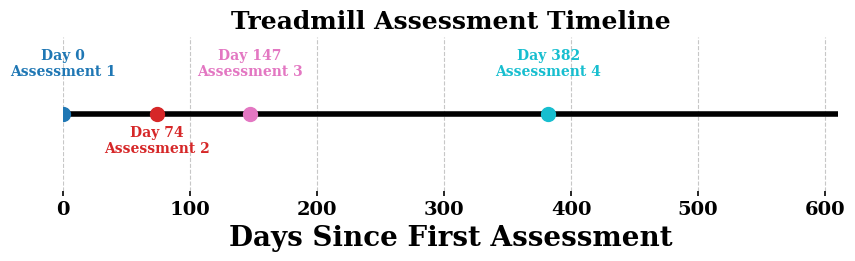

Timeline saved as treadmill_assessment_timeline.png in the figures directory.


C:\Users\port970\AppData\Local\Temp\ipykernel_39368\3236650347.py:49: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax2.boxplot(bws_levels, labels=['High BWS', 'Medium BWS'], patch_artist=True, showfliers=False,


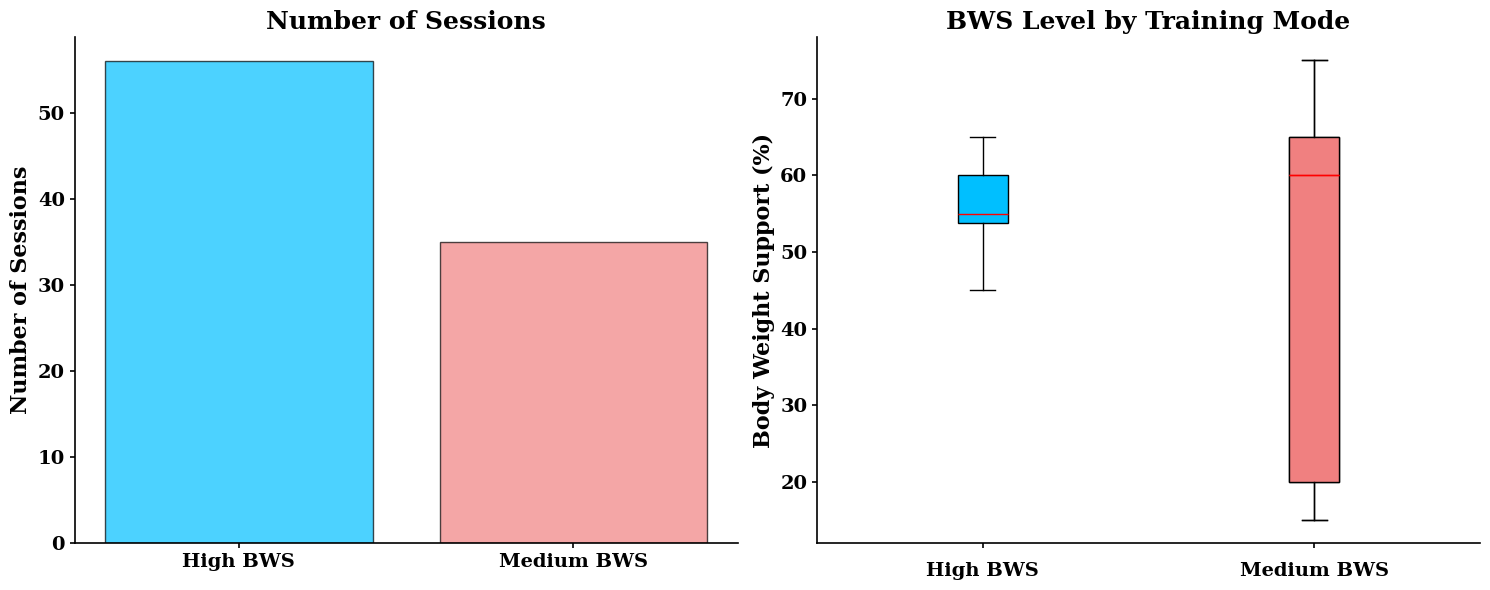


The training summary graph provides an overview of the participant's training sessions with different levels of body weight support (BWS). The level of BWS shown is the percentage of body weight support provided by the machine, meaning the participant is supporting the remainder to reach 100%. The participant completed 56 high BWS sessions with an average support level of 56.70% and spent a total of 43.68 hours in these sessions. Additionally, 35 medium BWS sessions were completed with an average support level of 45.37% and a total of 26.75 hours spent. The first subplot illustrates the total number of sessions completed with high and medium BWS. The second subplot presents a box plot showing the distribution of BWS levels for each training mode. The high BWS sessions are designed to provide more assistance, which helps participants maintain a steady gait while reducing joint stress. In contrast, the medium BWS sessions offer moderate support, encouraging participants to bear more of 

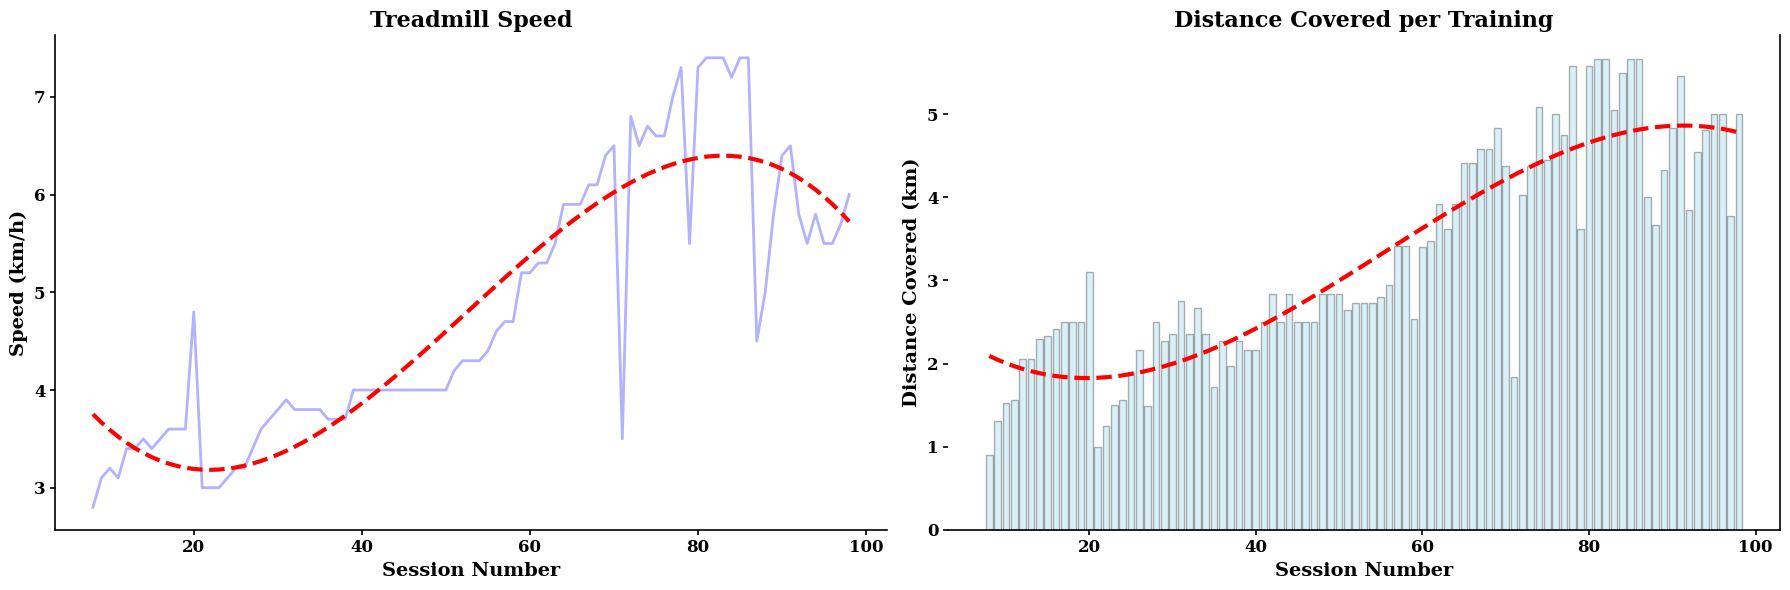


The plot on the left provides an overview of the participant's treadmill speed progression during each session.
The participant started training at a speed of 2.8 km/h and reached a maximum of 7.4 km/h, signifying an increase of 4.6 km/h.
The plot on the right presents the distance covered during each session, along with a fitted trendline to show the overall trend in distance.
The participant started by covering a distance of 0.9 km and reached a maximum of 5.7 km per session, signifying an increase of 4.8 km.
This visualization provides insight into the participant's performance and improvements in terms of speed and distance covered over time.


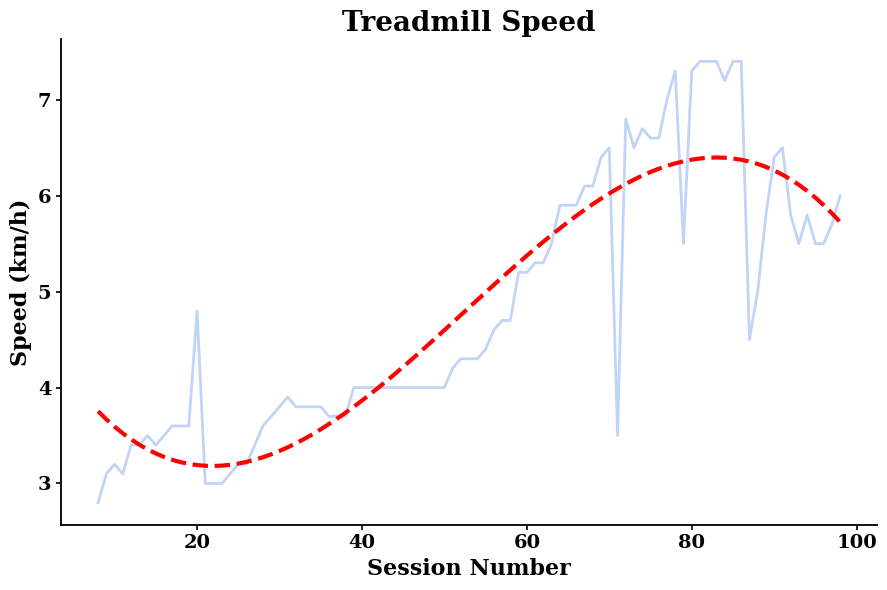

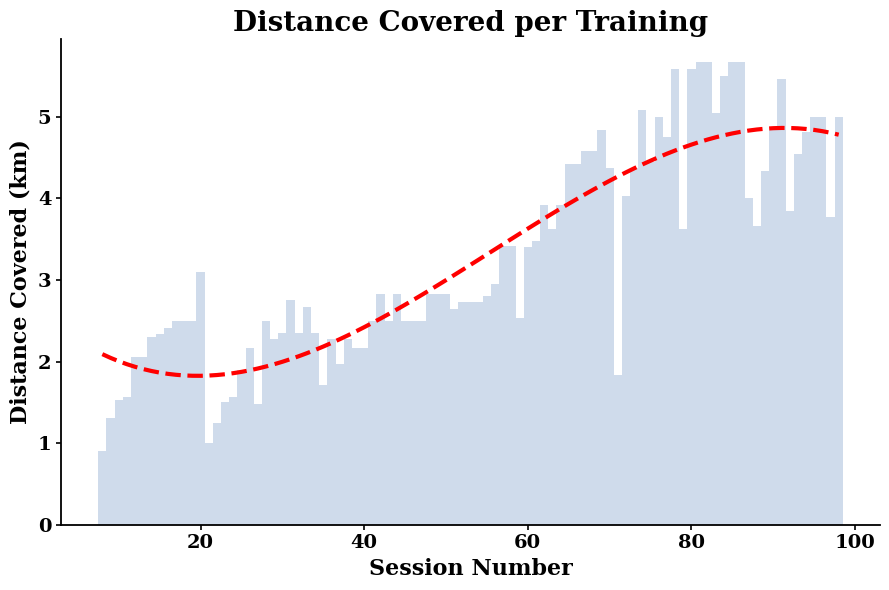


The plot 'Treadmill Speed' provides an overview of the participant's treadmill speed progression during each session.
The participant started training at a speed of 2.8 km/h and reached a maximum of 7.4 km/h, signifying an increase of 4.6 km/h.
The plot 'Distance Covered per Training' presents the distance covered during each session, along with a fitted trendline to show the overall trend in distance.
The participant started by covering a distance of 0.9 km and reached a maximum of 5.7 km per session, signifying an increase of 4.8 km.
This visualization provides insight into the participant's performance and improvements in terms of speed and distance covered over time.


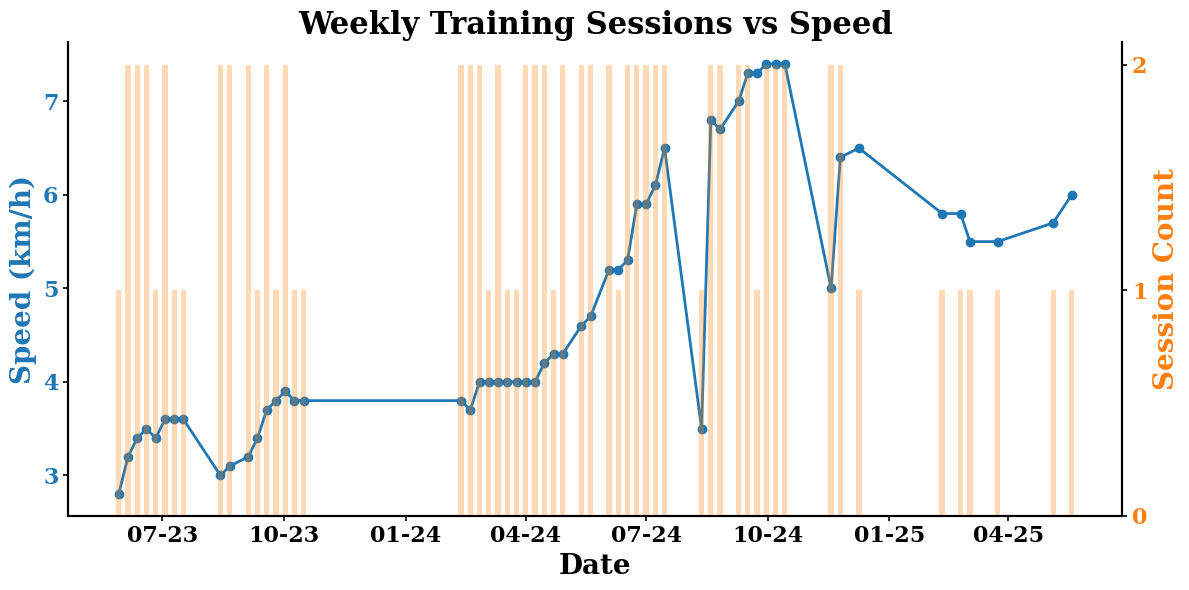

C:\git\alterg-pipeline\notebooks\training\docs\figures\training
C:\git\alterg-pipeline\notebooks\training\docs\figures\training\training_density_vs_maxspeed.png
Plotted 56 weeks. Speed and session count shown for each week.


In [58]:
#dirs
FIGURE_DIR = Path("docs/figures/training")
FIGURE_DIR.mkdir(parents=True, exist_ok=True)
# Load the CSV file
df = pd.read_csv('F:\AlterG\Reports\Data\RedCap.csv')

# Extract data for participant with study ID 1
participant_data = extract_participant_data(df, 1)

print_basic_info_for_report(participant_data)

# Print assessment dates and temporal overview
extract_and_print_assessment_dates(participant_data)

# Plot the timeline of treadmill assessments
plot_timeline(participant_data)
# Plot the training summary
plot_training_summary(participant_data)


training_performance(participant_data)

training_performance_separate(participant_data)


training_rows = df[
    (df['study_id'] == 1) &  # Change "1" if needed for a different participant
    (df['redcap_repeat_instrument'] == 'training_day') &
    (df['training_date'].notna())
].copy()

plot_training_density_vs_max_speed(training_rows)


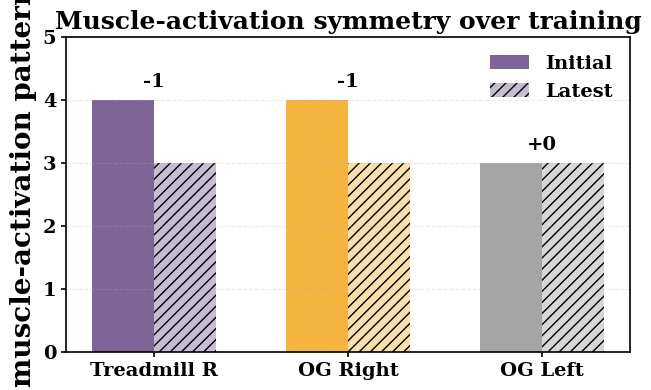

In [52]:
# --- Clustered bars with rcParams already set ----------------------------------
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

FIGURE_DIR.mkdir(exist_ok=True, parents=True)   # ensure dir

# Data
initial = {"Treadmill R": 4, "OG Right": 4, "OG Left": 3}
latest  = {"Treadmill R": 3, "OG Right": 3, "OG Left": 3}
labels  = list(initial.keys())
colors  = ["#5D407D", "#F2A10F", "#8F8F8F"]

x      = np.arange(len(labels))
width  = 0.32

fig, ax = plt.subplots(figsize=(6.5, 4))

ax.bar(x - width/2, initial.values(), width, label="Initial", color=colors, alpha=0.8)
ax.bar(x + width/2, latest.values(),  width, label="Latest",  color=colors, alpha=0.35, hatch="///")

# Δ labels
for xi, (v0, v1) in enumerate(zip(initial.values(), latest.values())):
    ax.text(xi, max(v0, v1) + 0.15, f"{v1 - v0:+}", ha="center", va="bottom", fontsize=14)

ax.set_ylabel("# muscle-activation patterns")
ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize=14)
ax.set_ylim(0, 5)
ax.set_title("Muscle-activation symmetry over training")
ax.legend(frameon=False, loc="upper right")
ax.grid(axis="y", linestyle="--", alpha=0.25)

plt.tight_layout()
plt.savefig(FIGURE_DIR / "muscle_pattern_symmetry_bars.png", dpi=300)
plt.show()



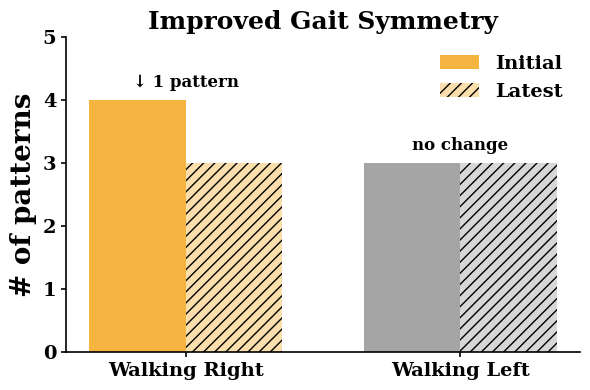

In [45]:
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

# ----------------------------------------------------
# 1.  Data  – only over-ground (“Walking”) left & right
initial = {"Walking Right": 4, "Walking Left": 3}
latest  = {"Walking Right": 3, "Walking Left": 3}
labels  = list(initial.keys())
colors  = ["#F2A10F", "#8F8F8F"]          # keep R / L distinct
# ----------------------------------------------------

FIGURE_DIR.mkdir(parents=True, exist_ok=True)

x, width = np.arange(len(labels)), 0.35

fig, ax = plt.subplots(figsize=(6, 4))

# Initial vs Latest bars
ax.bar(x - width/2, initial.values(), width,
       label="Initial", color=colors, alpha=0.80)
ax.bar(x + width/2, latest.values(),  width,
       label="Latest",  color=colors, alpha=0.35, hatch="///")

# Δ labels above each pair
for xi, (v0, v1) in enumerate(zip(initial.values(), latest.values())):
    delta = v1 - v0
    if delta == 0:
        label = "no change"
    elif delta > 0:
        label = f"↑ {delta} pattern" if delta == 1 else f"↑ {delta} patterns"
    else:
        label = f"↓ {abs(delta)} pattern" if delta == -1 else f"↓ {abs(delta)} patterns"
    ax.text(xi, max(v0, v1) + 0.15, label,
            ha="center", va="bottom", fontsize=12, weight="bold")

# Styling (uses your global rcParams for fonts)
ax.set_ylabel("# of patterns")
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylim(0, 5)
ax.set_title("Improved Gait Symmetry")
ax.grid(False)
ax.legend(frameon=False, loc="upper right")
ax = plt.gca()
for pos in ['left', 'bottom']:
      ax.spines[pos].set_visible(True)
for pos in ['right', 'top']:
       ax.spines[pos].set_visible(False)
plt.tight_layout()
plt.savefig(FIGURE_DIR / "muscle_pattern_symmetry_bars.png", dpi=300)
plt.show()


In [44]:
def plot_calendar_heatmap(training_rows):
    """
    Plot a calendar-style heatmap showing session count per day (Mon–Fri).
    Each cell = 1 calendar day. Accepts only pre-filtered training session rows.
    """
    import seaborn as sns
    import matplotlib.ticker as ticker

    df = training_rows.copy()
    df['training_date'] = pd.to_datetime(df['training_date'], format='%d/%m/%Y %H:%M', errors='coerce')
    df = df.dropna(subset=['training_date'])

    if df.empty:
        print("No valid training_date entries.")
        return

    session_counts = df.groupby(df['training_date'].dt.date).size()
    print("Session counts (top 5):")
    print(session_counts.head())

    full_index = pd.date_range(session_counts.index.min(), session_counts.index.max(), freq='D')
    heatmap_df = pd.DataFrame(index=full_index)
    heatmap_df['count'] = session_counts
    heatmap_df['count'] = heatmap_df['count'].fillna(0).astype(int)

    heatmap_df['dow'] = heatmap_df.index.weekday
    heatmap_df['week'] = heatmap_df.index.to_period('W').start_time

    # Only Monday–Friday
    heatmap_df = heatmap_df[heatmap_df['dow'] < 5]

    pivot = heatmap_df.pivot_table(index='dow', columns='week', values='count', fill_value=0)
    pivot = pivot.astype(int)
    
    fig, ax = plt.subplots(figsize=(len(pivot.columns) * 0.35, 2.7))
    sns.heatmap(
        pivot,
        ax=ax,
        cmap='Blues',
        linewidths=0.3,
        linecolor='gray',
        cbar=False,  # <--- No colorbar
        square=False,
        annot=True, fmt="d", annot_kws={"size": 6}
    )

    ax.set_yticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri'], rotation=0)
    ax.set_xlabel('Week Starting')
    ax.set_ylabel('')
    ax.set_title('Training Session Calendar Heatmap', fontsize=13)
    ax.tick_params(axis='x', labelrotation=90)
    ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

    plt.tight_layout()
    plt.savefig(FIGURE_DIR / 'calendar_heatmap_fixed.png', bbox_inches='tight')
    plt.show()

    print(f"\n✓ Total sessions (rows): {len(df)}")
    print(f"✓ Unique training days: {df['training_date'].dt.date.nunique()}")






Session counts (top 5):
training_date
2023-06-02    1
2023-06-06    1
2023-06-09    1
2023-06-13    1
2023-06-16    1
dtype: int64


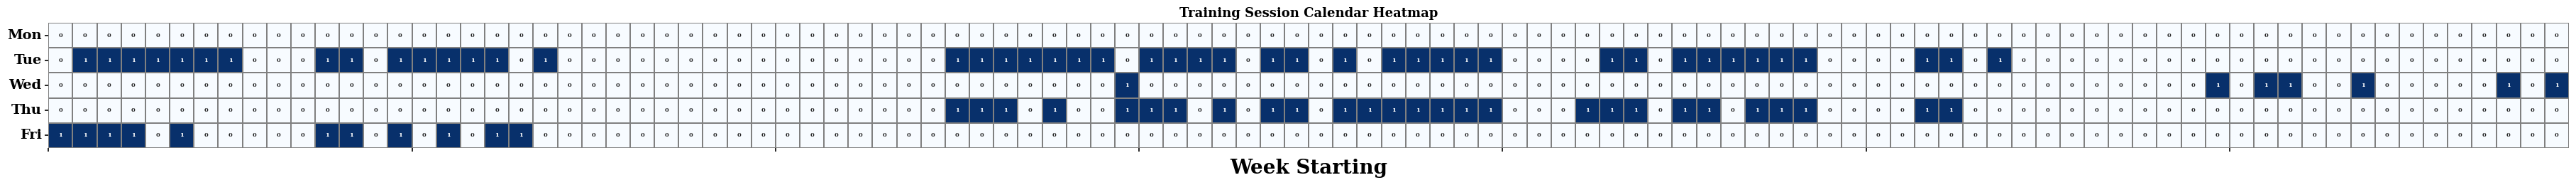


✓ Total sessions (rows): 90
✓ Unique training days: 90


In [43]:
training_rows = df[
    (df['study_id'] == 1) &  # Replace 1 with Maia's actual study_id if needed
    (df['redcap_repeat_instrument'] == 'training_day') &
    (df['training_date'].notna())
].copy()

plot_calendar_heatmap(training_rows)

In [10]:
print(FIGURE_DIR)



docs\figures\training
